In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy.io as sci

### Load the data

In [2]:
audio = np.random.randint(1, 10, 2912)

# Q1

# a)

### Plot a line graph of data

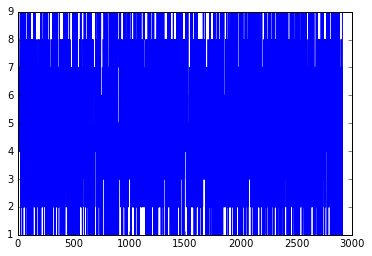

In [3]:
plt.plot(audio)

### Plot histogram of data

(array([ 314.,  344.,  352.,  321.,  311.,  325.,  317.,  326.,  302.]),
 array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 <a list of 9 Patch objects>)

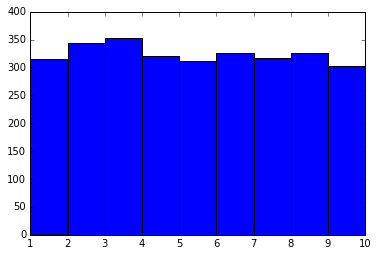

In [4]:
bins = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
plt.hist(audio, bins)

# b)

### Generate the matrix

In [5]:
C = len(audio) // 21
throw_away = len(audio) % 21
print len(audio)
audio = audio[:-throw_away]
print len(audio)
audio = audio.reshape(C, 21)
matrix = np.asmatrix(audio)

2912
2898


In [6]:
audio.shape

(138, 21)

In [7]:
audio

array([[4, 1, 6, ..., 4, 4, 6],
       [7, 8, 8, ..., 9, 2, 6],
       [6, 7, 3, ..., 5, 6, 2],
       ..., 
       [3, 1, 9, ..., 6, 4, 3],
       [1, 2, 9, ..., 9, 6, 7],
       [2, 5, 5, ..., 2, 4, 5]])

### Randomly shuffle the rows of the matrix

In [8]:
np.random.seed(0)
np.random.shuffle(audio)

In [9]:
print audio

[[6 1 5 ..., 1 7 2]
 [9 7 3 ..., 2 6 8]
 [3 9 6 ..., 2 7 8]
 ..., 
 [4 3 5 ..., 3 4 9]
 [3 6 2 ..., 4 9 8]
 [3 9 6 ..., 7 4 8]]


### Split into training, test and validation sets

In [10]:
train_size = np.floor(0.7 * C)
test_size = np.floor(0.15 * C)
val_size = np.floor(0.15 * C)

In [11]:
train_set = audio[0:train_size]
train_set.shape

/Users/thomascartwright/anaconda/envs/gl-env/lib/python2.7/site-packages/ipykernel/__main__.py:1: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  if __name__ == '__main__':


(96, 21)

In [12]:
test_set = audio[train_size+1:train_size+test_size]
test_set.shape

/Users/thomascartwright/anaconda/envs/gl-env/lib/python2.7/site-packages/ipykernel/__main__.py:1: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  if __name__ == '__main__':


(19, 21)

In [13]:
val_set = audio[train_size+test_size+1:]
val_set.shape

/Users/thomascartwright/anaconda/envs/gl-env/lib/python2.7/site-packages/ipykernel/__main__.py:1: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  if __name__ == '__main__':


(21, 21)

### Train

In [14]:
X_shuf_train = train_set[:, :20]
X_shuf_train.shape

(96, 20)

In [15]:
y_shuf_train = train_set[:, 20:21]
y_shuf_train.shape

(96, 1)

### Validation

In [16]:
X_shuf_val = val_set[:, :20]
X_shuf_val.shape

(21, 20)

In [17]:
y_shuf_val = val_set[:, 20:21]
y_shuf_val.shape

(21, 1)

### Test

In [18]:
X_shuf_test = test_set[:, :20]
X_shuf_test.shape

(19, 20)

In [19]:
y_shuf_test = test_set[:, 20:21]
y_shuf_test.shape

(19, 1)

# Q2

### Plot one row of X_shuf_train

In [54]:
x_ticks = [round(x/float(20), 2) for x in range(0, 20)]
x_ticks = np.array(x_ticks)
x_ticks

array([ 0.  ,  0.05,  0.1 ,  0.15,  0.2 ,  0.25,  0.3 ,  0.35,  0.4 ,
        0.45,  0.5 ,  0.55,  0.6 ,  0.65,  0.7 ,  0.75,  0.8 ,  0.85,
        0.9 ,  0.95])

In [55]:
row_number = np.random.randint(0, X_shuf_train.shape[0])
row_number

0

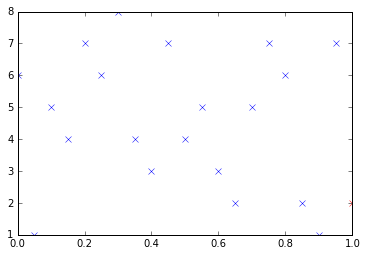

In [56]:
X_shuf_train_row = X_shuf_train[row_number, :]
plt.plot(x_ticks, X_shuf_train_row, 'bx')
plt.plot([1], y_shuf_train[row_number, :], 'rx')
plt.show()

### Fit Straight Line Through Points

In [57]:
def phi_linear(Xin):
    return np.array([np.ones(len(Xin)), Xin]).T

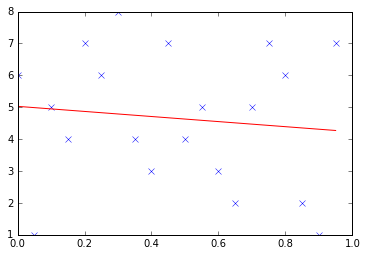

In [71]:
w_fit = np.linalg.lstsq(phi_linear(x_ticks), X_shuf_train_row)[0]
line = np.dot(phi_linear(x_ticks), w_fit)
plt.plot(x_ticks, X_shuf_train_row, 'bx')
plt.plot(x_ticks, line, 'r-')
plt.show()

### Fit Polynomial

In [74]:
def phi_poly(Xin):
    return np.array([np.ones(len(Xin)), Xin, Xin**2, Xin**3, Xin**4]).T

In [81]:
poly_ticks = np.append(x_ticks, [1])
w_fit = np.linalg.lstsq(phi_poly(x_ticks), X_shuf_train_row)[0]
poly_line = np.dot(phi_poly(poly_ticks), w_fit)
